In [1]:
import pandas as pd
import geopandas as gpd

regions_df = pd.read_csv('../../data/raw/location/sa2_to_rental_suburb_groups.csv')
regions_df['geometry'] = gpd.GeoSeries.from_wkt(regions_df['geometry'])

regions_df = gpd.GeoDataFrame(
    regions_df,
    geometry='geometry'
)

def fix_col_names(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')

In [43]:
import rasterio
from rasterio.mask import mask
import numpy as np

LAND_COVER_PATH = '../../data/landing/VIC_LANDCOVER_TS'

def get_land_cover(start_year, end_year):
    return LAND_COVER_PATH + f'/VIC_LANDCOVER_TS_20{start_year:02d}_{end_year:02d}.tif'

# Open the .tif file
with rasterio.open(get_land_cover(15, 19)) as src:
    # Read the first band of the raster data
    land_cover_data = src.read(1)  # Assuming land cover data is in the first band
    
    # Get the affine transformation and metadata
    transform = src.transform
    crs = src.crs

if regions_df.crs is None:
    regions_df = regions_df.set_crs('EPSG:4326')

regions_df = regions_df.to_crs(crs)

In [47]:

# 1   - Built environment
# 2   - Urban area
# 3   - Disturbed ground
# 4   - Exotic pasture / grassland
# 5   - Dryland cropping
# 6   - Other exotic tree cover
# 7   - Hardwood plantation
# 8   - Horticulture / irrigated pasture
# 9   - Mangrove vegetation
# 10 - Native pasture / grassland
# 11 - Native scrubland
# 12 - Treed native vegetation
# 13 - Scattered native trees
# 14 - Natural low cover
# 15 - Conifer plantation
# 16 - Saltmarsh vegetation
# 17 - Water
# 18 - Wetland - seasonal
# 19 - Wetland - perennial

# Initialize an empty list to store results
results = []
time_periods = [(0, 5), (5, 10), (10, 15), (15, 19)]

# loop over each time period

for time_period in time_periods:
    # Loop over each region
    for index, region in regions_df.iterrows():
        # Mask the raster to the current region
        geom = [region['geometry']]  # Geometry of the region
        with rasterio.open(get_land_cover(time_period[0], time_period[1])) as src:
            # Clip the raster to the region's geometry
            out_image, out_transform = mask(src, geom, crop=True)
            
            # Flatten the array to 1D
            out_image_flat = out_image.flatten()
            
            # Remove nodata values (if any)
            out_image_flat = out_image_flat[out_image_flat != src.nodata]
            
            # Calculate total pixels in the region
            total_pixels = len(out_image_flat)
            
            # Calculate the number of urban pixels
            built_pixels = np.isin(out_image_flat, [1]).sum()
            urban_pixels = np.isin(out_image_flat, [2]).sum()
            disturbed_pixels = np.isin(out_image_flat, [3]).sum()
            water_pixels = np.isin(out_image_flat, [17]).sum()

            developed_pixels = built_pixels + urban_pixels + disturbed_pixels
            nature_pixels = total_pixels - developed_pixels - water_pixels
            
            # Calculate the percentage of urban pixels
            if total_pixels > 0:
                built_percentage = (built_pixels / total_pixels)
                urban_percentage = (urban_pixels / total_pixels)
                disturbed_percentage = (disturbed_pixels / total_pixels)
                water_percentage = (water_pixels / total_pixels)
                developed_percentage = (developed_pixels / total_pixels)
                nature_percentage = (nature_pixels / total_pixels)

            else:
                urban_percentage = 0
            
            # add 1 for the final batch so it goes until 2019
            time_period_range = time_period if time_period[1] != 19 else (15, 20)
            for i in range(time_period_range[0], time_period_range[1]):
                for j in (1, 2, 3, 4):
                # Store the result
                    results.append({
                        'suburbs': region['suburbs'],  # Assuming there's a 'region_id' column
                        'total_area': total_pixels * (src.transform[0] ** 2),  # Pixel area in map units
                        'developed_area': developed_pixels * (src.transform[0] ** 2),
                        'built_percentage': built_percentage,
                        'urban_percentage': urban_percentage,
                        'disturbed_percentage': disturbed_percentage,
                        'water_percentage': water_percentage,
                        'developed_percentage': developed_percentage,
                        'nature_percentage': nature_percentage,
                        'year': 2000 + i,
                        'quarter': j
                    })

results_df = pd.DataFrame(results)

results_df.sort_values('nature_percentage', ascending=True).head(20)

,suburbs,total_area,developed_area,built_percentage,urban_percentage,disturbed_percentage,water_percentage,developed_percentage,nature_percentage,year,quarter
9763,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2015,4
9762,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2015,3
9761,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2015,2
9760,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2015,1
9779,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2019,4
9778,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2019,3
9767,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2016,4
9766,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2016,3
9774,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2018,3
9775,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2018,4


In [48]:

# 1   - Built environment
# 2   - Urban area
# 3   - Disturbed ground
# 4   - Exotic pasture / grassland
# 5   - Dryland cropping
# 6   - Other exotic tree cover
# 7   - Hardwood plantation
# 8   - Horticulture / irrigated pasture
# 9   - Mangrove vegetation
# 10 - Native pasture / grassland
# 11 - Native scrubland
# 12 - Treed native vegetation
# 13 - Scattered native trees
# 14 - Natural low cover
# 15 - Conifer plantation
# 16 - Saltmarsh vegetation
# 17 - Water
# 18 - Wetland - seasonal
# 19 - Wetland - perennial

# Initialize an empty list to store results
results = []
time_periods = [(0, 5), (5, 10), (10, 15), (15, 19)]

# loop over each time period

for time_period in time_periods:
    # Loop over each region
    for index, region in regions_df.iterrows():
        # Mask the raster to the current region
        geom = [region['geometry']]  # Geometry of the region
        with rasterio.open(get_land_cover(time_period[0], time_period[1])) as src:
            # Clip the raster to the region's geometry
            out_image, out_transform = mask(src, geom, crop=True)
            
            # Flatten the array to 1D
            out_image_flat = out_image.flatten()
            
            # Remove nodata values (if any)
            out_image_flat = out_image_flat[out_image_flat != src.nodata]
            
            # Calculate total pixels in the region
            total_pixels = len(out_image_flat)
            
            # Calculate the number of urban pixels
            built_pixels = np.isin(out_image_flat, [1]).sum()
            urban_pixels = np.isin(out_image_flat, [2]).sum()
            disturbed_pixels = np.isin(out_image_flat, [3]).sum()
            water_pixels = np.isin(out_image_flat, [17]).sum()

            developed_pixels = built_pixels + urban_pixels + disturbed_pixels
            nature_pixels = total_pixels - developed_pixels - water_pixels
            
            # Calculate the percentage of urban pixels
            if total_pixels > 0:
                built_percentage = (built_pixels / total_pixels)
                urban_percentage = (urban_pixels / total_pixels)
                disturbed_percentage = (disturbed_pixels / total_pixels)
                water_percentage = (water_pixels / total_pixels)
                developed_percentage = (developed_pixels / total_pixels)
                nature_percentage = (nature_pixels / total_pixels)

            else:
                urban_percentage = 0

            # Store the result
            results.append({
                'suburbs': region['suburbs'],  # Assuming there's a 'region_id' column
                'total_area': total_pixels * (src.transform[0] ** 2),  # Pixel area in map units
                'developed_area': developed_pixels * (src.transform[0] ** 2),
                'built_percentage': built_percentage,
                'urban_percentage': urban_percentage,
                'disturbed_percentage': disturbed_percentage,
                'water_percentage': water_percentage,
                'developed_percentage': developed_percentage,
                'nature_percentage': nature_percentage,
                'year': f'20{time_period[0]:02d}-20{time_period[1]:02d}'
            })

results_df_grouped = pd.DataFrame(results)

results_df_grouped.sort_values('nature_percentage', ascending=True).head(20)

,suburbs,total_area,developed_area,built_percentage,urban_percentage,disturbed_percentage,water_percentage,developed_percentage,nature_percentage,year
488,Fitzroy,1378125.0,1368750.0,0.148753,0.842177,0.002268,0.0,0.993197,0.006803,2015-2019
344,Fitzroy,1378125.0,1368125.0,0.148753,0.840816,0.003175,0.0,0.992744,0.007256,2010-2015
200,Fitzroy,1378125.0,1367500.0,0.180045,0.807710,0.004535,0.0,0.992290,0.007710,2005-2010
56,Fitzroy,1378125.0,1365625.0,0.187755,0.798639,0.004535,0.0,0.990930,0.009070,2000-2005
537,Prahran-Windsor,2902500.0,2863750.0,0.059432,0.922265,0.004953,0.0,0.986649,0.013351,2015-2019
482,Elsternwick,2860625.0,2811250.0,0.022941,0.955211,0.004588,0.0,0.982740,0.017260,2015-2019
434,Armadale,2181875.0,2141250.0,0.022057,0.953309,0.006015,0.0,0.981381,0.018619,2015-2019
451,Brunswick,5138750.0,5030000.0,0.120530,0.850036,0.008270,0.0,0.978837,0.021163,2015-2019
249,Prahran-Windsor,2902500.0,2839375.0,0.069983,0.901593,0.006675,0.0,0.978252,0.021748,2005-2010
393,Prahran-Windsor,2902500.0,2838125.0,0.059001,0.914083,0.004737,0.0,0.977821,0.022179,2010-2015


In [49]:
results_df.to_csv('../../data/raw/land_cover/land_cover.csv')
results_df_grouped.to_csv('../../data/raw/land_cover/land_cover_grouped.csv')

/tmp/ipykernel_1176/2048094535.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


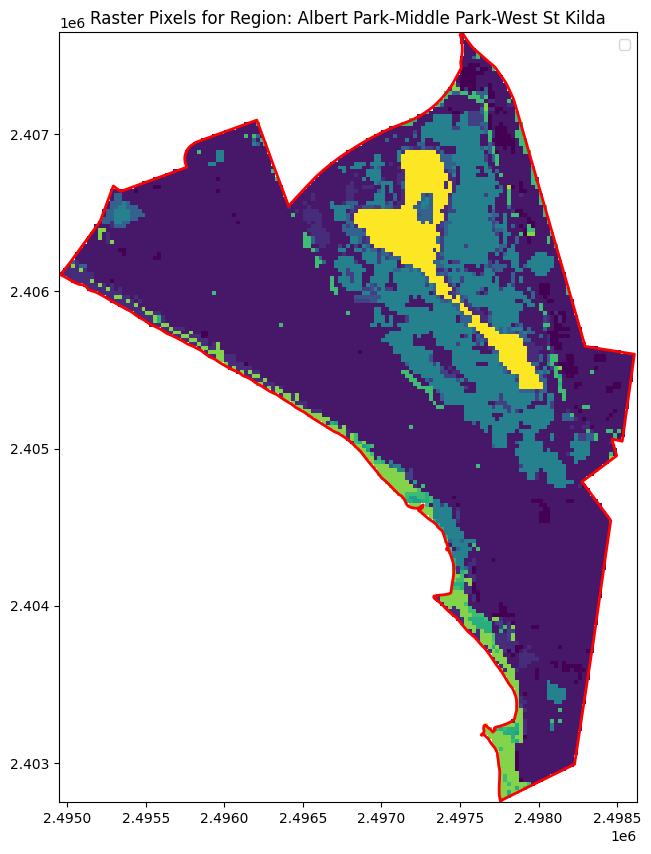

In [36]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask

# Example: Urban classes and raster file path
LAND_COVER_PATH = '../../data/landing/VIC_LANDCOVER_TS/VIC_LANDCOVER_TS_2015_19.tif'

# Select a specific region (for example, the first region)
region = regions_df.iloc[0]  # You can change this index to select another region
region_geom = [region['geometry']]  # Geometry of the selected region

# Open the raster and mask it with the region's geometry
with rasterio.open(LAND_COVER_PATH) as src:
    # Clip the raster to the region
    out_image, out_transform = mask(src, region_geom, crop=True)
    
    # Remove nodata values (for visualization purposes)
    out_image = np.ma.masked_equal(out_image, src.nodata)

    # Plot the raster and the region's boundary
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show the clipped raster
    show(out_image, transform=out_transform, ax=ax)
    
    # Plot the region's boundary (overlay the region)
    region_gdf = gpd.GeoDataFrame(geometry=region_geom, crs=regions_df.crs)
    region_gdf.boundary.plot(ax=ax, color='red', linewidth=2)  # Plot the boundary in red

    ax.legend()
    
    # Customize the plot
    plt.title(f"Raster Pixels for Region: {region['suburbs']}")
    plt.show()
